# Add Folders to Path

In [1]:
%%time
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-4])

# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/utils")

# add integration folder to current working path
sys.path.append(parent_directory+"/subfunctions/integration")

# add EllipticOECS folder to current working path in order to access the functions
sys.path.append(parent_directory+"/demos/AdvectiveBarriers/EllipticOECS")

# Overview

In the following notebok we visualize elliptic LCS in the Agulhas region from the AVISO dataset using the Polar Rotation Angle. The notebook is structured as follows:

1. Import data from the file 'AVISO.mat' stored in the folder 'data'
<br />
2. Define computational parameters (such as the number of cores) and data
 <br />
3. Define spatio-temporal domain.
 <br />
4. Interpolate velocity from the (discrete) gridded data
 <br />
5. Elliptic OECS:

    * Compute gradient of velocity field $ \mathbf{\nabla v}(\mathbf{x}. t) $ over meshgrid using an auxiliary meshgrid. 
   
    * Compute rate of strain: 
    
    \begin{equation} \mathbf{S}(\mathbf{x}, t) = \begin{pmatrix} S_{11} & S_{12} \\ S_{11} & S_{12} \end{pmatrix} = \dfrac{1}{2}(\mathbf{\nabla v}(\mathbf{x}, t)+\mathbf{\nabla v}(\mathbf{x}, t)^T)  \end{equation}
    
    * Elliptic OECSs are closed null geodesics of the one-parameter family of Lorentzian metrics:
    
    \begin{equation}
    \mathrm{A_{\mu}(\mathbf{x},t)} = S(\mathbf{x}, t) - \mu\mathbf{I}, 
    \end{equation} with $ \mu \in \mathbb{R}$
    
    Closed null geodesics are closed curves of the system of ODE:
    
    \begin{align*}
    \dfrac{d \mathbf{x}}{ds} &= \mathbf{e}_{\phi}(s) = \begin{pmatrix} \cos(\phi(s)) \\ \sin(\phi(s)) \end{pmatrix} \\
    \dfrac{d \phi}{ds} &= - \dfrac{\langle \mathbf{e}_{\phi}(s), (\nabla_x A(\mathbf{x}) \mathbf{e}_{\phi}(s)) \mathbf{e}_{\phi}(s) \rangle}{2 \langle \mathbf{e}_{\phi}, R^T A(\mathbf{x}) \mathbf{e}_{\phi}(s)}, 
    \end{align*} where $ R = \begin{pmatrix} 0 && -1 \\ 1 && 0\end{pmatrix} $. 
    
  $ \dfrac{d \phi}{ds} $ depends both on $ \mathbf{x} $ and on $ \phi $ and can be evaluated through interpolation by first computing $ \dfrac{\langle \mathbf{e}_{\phi}(s), (\nabla_x A(\mathbf{x}) \mathbf{e}_{\phi}(s)) \mathbf{e}_{\phi}(s) \rangle}{2 \langle \mathbf{e}_{\phi}, R^T A(\mathbf{x}) \mathbf{e}_{\phi}(s)} $ over the spatial meshgrid (X, Y) as well as over $ \phi \in [0, 2\pi] $. 
    
  It holds:
  \begin{equation}
  \dfrac{d \phi}{ds} = -\dfrac{\cos^2(\phi)[S_x^{11}(\mathbf{x})(\mathbf{x})\cos(\phi)+S_y^{11}(\mathbf{x})\sin(\phi)]+[S_x^{12}(\mathbf{x})\cos(\phi)+S_y^{11}(\mathbf{x})(\mathbf{x})\sin(\phi)]\sin(2\phi)+\sin^2(\phi)[S_x^{22}(\mathbf{x})\cos(\phi)+S_y^{22}(\mathbf{x})\sin(\phi)]}{\sin(2\phi)[S^{22}(\mathbf{x})-S^{11}(\mathbf{x})]+2\cos(2\phi)S^{12}(\mathbf{x})}
  \end{equation}
    
  The set of initial conditions is given by:
    \begin{equation}
    (\mathbf{x}_0, \phi_0)_{\mu} = \lbrace (\mathbf{x}_0(\mu, \phi = 0), 0) \in V: S^{11}(\mathbf{x})- \mu = 0 \rbrace
    \end{equation}
    
  Furthermore the system of ODE is only well defined for
    
  \begin{equation}
    \sin(2\phi)[S^{22}(\mathbf{x})-S^{11}(\mathbf{x})]+2\cos(2\phi)S^{12}(\mathbf{x}) \neq 0
  \label{eq: DOE}
  \end{equation}
  
  If the trajectory violates condition $ \ref{eq: DOE} $, then the integration is stopped. 

# Import Data

In [2]:
%%time
import scipy.io as sio

#Import velocity data from file in data-folder
mat_file = sio.loadmat('../../../../data/Aviso/AVISO.mat')

U = mat_file['u']
V = mat_file['v']
x = mat_file['x']
y = mat_file['y']
time_data = mat_file['t']

CPU times: user 127 ms, sys: 28.5 ms, total: 156 ms
Wall time: 156 ms


# Computational parameters and data

Here we define the computational parameters and the data.

In [3]:
import numpy as np

# number of cores to be used for parallel computing
Ncores = 15

# time resolution of data
dt_data = time_data[0, 1]-time_data[0,0]

# periodic boundary conditions
periodic_x = False
periodic_y = False
periodic = [periodic_x, periodic_y]

# unsteady velocity field
bool_unsteady = True

# defined domain
# This array denotes where the velocity field is defined (=1) and where it is not defined (=0)
defined_domain = np.isfinite(U[:,:,0]).astype(int)

## meshgrid
X, Y = np.meshgrid(x, y)

## resolution of meshgrid
dx_data = X[0,1]-X[0,0]
dy_data = Y[1,0]-Y[0,0]

delta = [dx_data, dy_data]

# Spatio-temporal domain

Here we define the spatio-temporal domain over which to consider the dynamical system.

In [4]:
%%time
# Time
t_OECS = 0

# store time in array
time = np.array([t_OECS])

# domain boundary (in degrees)
xmin = -3
xmax = 1
ymin = -32
ymax = -24

# make sure that the spatio-temporal you defined are within the domain of the data
assert (xmax <= np.max(X) and xmin >= np.min(X) and ymin >= np.min(Y) and ymax <= np.max(Y) and t_OECS >= np.min(time_data) and t_OECS <= np.max(time_data)),"The domains you are chooising are outside the domain of the data!!!!! --> redefine spatial/temporal domain"

# spacing of meshgrid (in degrees)
dx = 0.02
dy = 0.02

x_domain = np.arange(xmin, xmax + dx, dx)
y_domain = np.arange(ymin, ymax + dy, dy)

X_domain, Y_domain = np.meshgrid(x_domain, y_domain)

CPU times: user 968 µs, sys: 1.15 ms, total: 2.12 ms
Wall time: 1.03 ms


# Interpolate Velocity

In order to evaluate the velocity field at arbitrary locations and times, we must interpolate the discrete velocity data. The interpolation with respect to time is always linear. The interpolation with respect to space can be chosen to be "cubic" or "linear".

In [5]:
%%time
# Import interpolation function for unsteady flow field
from ipynb.fs.defs.Interpolant import interpolant_unsteady

# set nan values to zero so that we can apply interpolant. Interpolant does not work if the array contains nan values
U[np.isnan(U)] = 0
V[np.isnan(V)] = 0

# Interpolate velocity data using cubic spatial interpolation
Interpolant = interpolant_unsteady(X, Y, U, V, time_data, method = "cubic")

CPU times: user 65.2 ms, sys: 15 ms, total: 80.2 ms
Wall time: 79.5 ms


# Rate of strain tensor over meshgrid of initial conditions

The rate of strain tensor $ S(\mathbf{x}, t) $ at time $ t $ is computed by iterating over meshgrid. The rate of strain tensor at point $ \mathbf{x} $ at time $ t $ is computed from the gradient of the velocity field by using an auxiliary meshgrid. 'aux_grid' specifies the ratio between the auxiliary grid and the original meshgrid. This parameter is generally chosen to be between $ [\dfrac{1}{5}, \dfrac{1}{10}] $. The computations are parallelized.

In [6]:
%%time
# Import package for progress bar
from tqdm.notebook import tqdm

# Import package for parallel computing
from joblib import Parallel, delayed

# Import gradient of velocity function
from ipynb.fs.defs.gradient_velocity import gradient_velocity

# Import Rate of Strain function
from ipynb.fs.defs.RateStrain import RateStrain

# Import package which checks particle location
from ipynb.fs.defs.check_location import check_location

# Define ratio of auxiliary grid spacing vs original grid_spacing
aux_grid_ratio = .2 # [1/5, 1/10]
aux_grid = [aux_grid_ratio*(X_domain[0, 1]-X_domain[0, 0]), aux_grid_ratio*(Y_domain[1, 0]-Y_domain[0, 0])]

def parallel_S(i):
    
    S_parallel = np.zeros((X_domain.shape[1], 2, 2))*np.nan
    
    for j in range(S_parallel.shape[0]):
        
        x = np.array([X_domain[i,j], Y_domain[i,j]])
  
        # only compute rate of strain for particles in region where velocity field is defined
        if check_location(X, Y, defined_domain, x)[0] == "IN":
        
            # Compute gradient of velocity
            grad_vel = gradient_velocity(t_OECS, x, X, Y, Interpolant, periodic, defined_domain, bool_unsteady, dt_data, delta, aux_grid)
            
            # Compute rate of strain at 'x'
            S_parallel[j, :, :] = RateStrain(grad_vel)
    
    return S_parallel

S = np.array(Parallel(n_jobs=Ncores, verbose = 0)(delayed(parallel_S)(i) for i in tqdm(range(X_domain.shape[0]))))

  0%|          | 0/401 [00:00<?, ?it/s]

CPU times: user 4.56 s, sys: 2.22 s, total: 6.78 s
Wall time: 12.8 s


# Compute tensorfield

In [7]:
# Import (cubic) RectBivariateSpline from scipy
from scipy.interpolate import RectBivariateSpline as RBS
        
# Compute gradients of elements of rate of strain tensor
S11 = S[:,:,0,0].copy()
S12 = S[:,:,0,1].copy()
S22 = S[:,:,1,1].copy()
    
# Interpolate elements of rate of strain tensor (per default: linear)
interp_S11 = RBS(Y_domain[:,0], X_domain[0,:], np.nan_to_num(S11, nan = 0.0), kx = 1, ky = 1)
interp_S12 = RBS(Y_domain[:,0], X_domain[0,:], np.nan_to_num(S12, nan = 0.0), kx = 1, ky = 1)
interp_S22 = RBS(Y_domain[:,0], X_domain[0,:], np.nan_to_num(S22, nan = 0.0), kx = 1, ky = 1)

# Initialize arrays
S11x = np.zeros((S.shape[0], S.shape[1]))*np.nan
S11y = np.zeros((S.shape[0], S.shape[1]))*np.nan
S12x = np.zeros((S.shape[0], S.shape[1]))*np.nan
S12y = np.zeros((S.shape[0], S.shape[1]))*np.nan
S22x = np.zeros((S.shape[0], S.shape[1]))*np.nan
S22y = np.zeros((S.shape[0], S.shape[1]))*np.nan
    
# Define auxilary meshgrid
rho_x = aux_grid[0]/2
rho_y = aux_grid[1]/2
        
#iterate over meshgrid
for i in range(X_domain.shape[0]):
        
    for j in range(Y_domain.shape[1]):
            
        x = [X_domain[i,j], Y_domain[i, j]]
        
        # compute derivatives using auxiliary grid and finite-differencing
        S11x[i, j] = (interp_S11(x[1], x[0]+rho_x)[0][0]-interp_S11(x[1], x[0]-rho_x)[0][0])/(2*rho_x)
        S11y[i, j] = (interp_S11(x[1]+rho_y, x[0])[0][0]-interp_S11(x[1]-rho_y, x[0])[0][0])/(2*rho_y)
        
        S12x[i, j] = (interp_S12(x[1], x[0]+rho_x)[0][0]-interp_S12(x[1], x[0]-rho_x)[0][0])/(2*rho_x)
        S12y[i, j] = (interp_S12(x[1]+rho_y, x[0])[0][0]-interp_S12(x[1]-rho_y, x[0])[0][0])/(2*rho_y)
            
        S22x[i, j] = (interp_S22(x[1], x[0]+rho_x)[0][0]-interp_S22(x[1], x[0]-rho_x)[0][0])/(2*rho_x)
        S22y[i, j] = (interp_S22(x[1]+rho_y, x[0])[0][0]-interp_S22(x[1]-rho_y, x[0])[0][0])/(2*rho_y)

# Interpolate $ \dot{\phi}(x, y, \phi)$ 

In [8]:
%%time
import time
# Import package for computing interpolant of phi_prime and the domain of existence
from ipynb.fs.defs.phi_prime import _phi_prime

# Interpolant phi_phrime, interpolant indicating domain of existence (= denominator of phi_prime)
interp_phi_prime, interp_DOE = _phi_prime(X_domain, Y_domain, S11, S12, S22, S11x, S11y, S12x, S12y, S22x, S22y)

CPU times: user 2.9 s, sys: 2.55 s, total: 5.45 s
Wall time: 1.48 s


# Elliptic OECSs

Elliptic OECSs are closed null geodesics of the one-parameter family of Lorentzian metrics $ S(\mathbf{x}, t) − \mu $. $ \mu ∈ \mathbb{R} $ denotes the tangential stretch rate along an elliptic OECS. For perfectly coherent elliptic OECS with no tangential stretching (=filamentation) it holds that $ \mu = 0 $.  

In [9]:
%%time
# import plotting library
import matplotlib.pyplot as plt
import matplotlib as mpl

# Import function to extract closed null geodesics
from ipynb.fs.defs.closed_null_geodesics import closed_null_geodesics

# extract elliptic OECS from closed null geodesics
from ipynb.fs.defs.elliptic_CS import elliptic_CS

# define mu range
mu_min = -0.01
mu_max = 0.01
n_mu = Ncores
mu_range = np.linspace(mu_min, mu_max, n_mu)

# threshold distance between starting and return point of trajectory
d_threshold = 0.02

# compute elliptic OECS
def compute_ellipitic_OECS(mu):
    
    # Define list storing x, y coordinates of elliptic OECS
    x_elliptic, y_elliptic = [], []
    
    # Find all closed null geodesics
    closed_NG, init_mu = closed_null_geodesics(X_domain, Y_domain, mu, interp_phi_prime, d_threshold, S11, defined_domain, interp_DOE)
    
    # Extract elliptic OECS
    x_elliptic, y_elliptic = elliptic_CS(closed_NG)
        
    return [x_elliptic, y_elliptic, init_mu]

# compute elliptic OECS with parallel computing
Elliptic_OECS = Parallel(n_jobs=Ncores, verbose = 0)(delayed(compute_ellipitic_OECS)(i) for i in mu_range)

CPU times: user 473 ms, sys: 180 ms, total: 653 ms
Wall time: 16.7 s


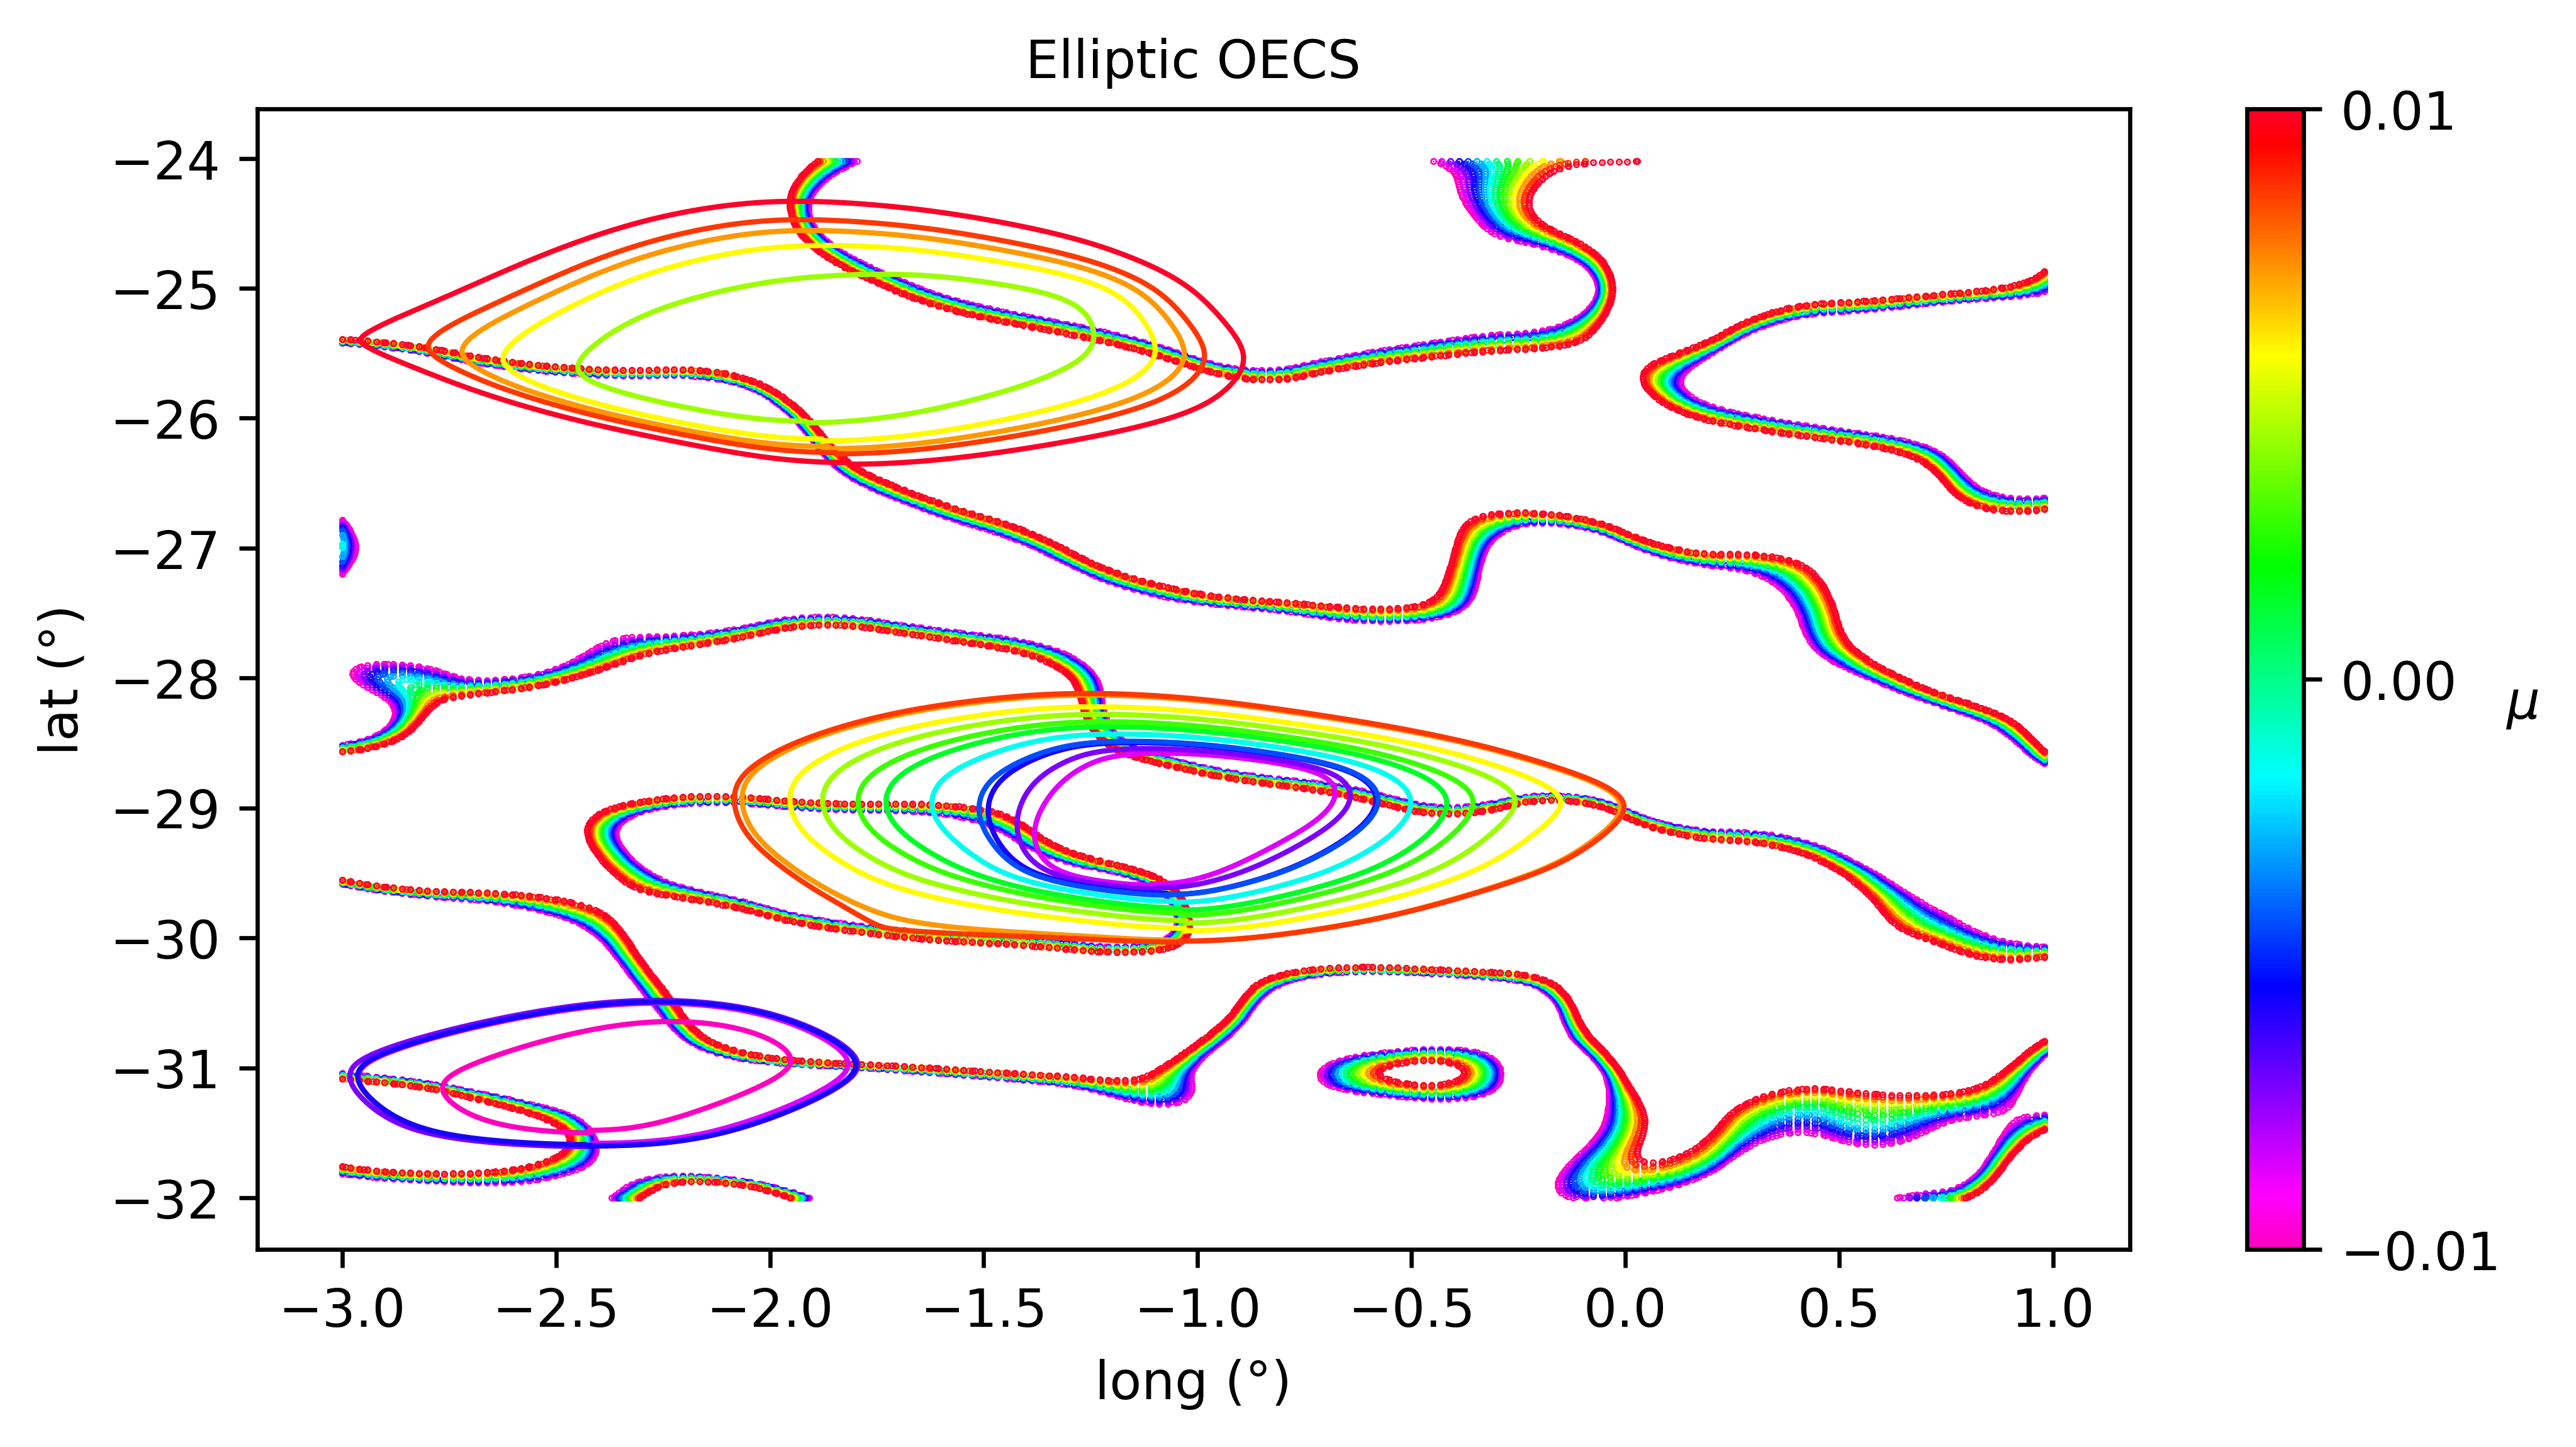

CPU times: user 1.28 s, sys: 28.2 ms, total: 1.3 s
Wall time: 1.3 s


In [10]:
%%time
######################################## Plot elliptic OECS ########################################

# import plotting library
import matplotlib.pyplot as plt
import matplotlib as mpl

# Define figure/axes
fig = plt.figure(figsize = (8, 4), dpi = 600)
ax = plt.axes()

# Define norm/cmap
norm = mpl.colors.Normalize(vmin=mu_range.min(), vmax=mu_range.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap='gist_rainbow_r')

# Iterate over all elliptic OECS and plot
for i in range(len(Elliptic_OECS)):
    
    # Plot initial conditions
    ax.scatter(Elliptic_OECS[i][2][0], Elliptic_OECS[i][2][1], color=cmap.to_rgba(mu_range[i]), s = 0.1)
    
    # Plot elliptic OECS
    if Elliptic_OECS[i][0] is not None:
        for j in range(len(Elliptic_OECS[i][0])):
            if Elliptic_OECS[i][0][j] is not None:
                ax.plot(Elliptic_OECS[i][0][j], Elliptic_OECS[i][1][j], c=cmap.to_rgba(mu_range[i]), linewidth = 1)

# Set axis labels
ax.set_xlabel("long (°)", fontsize = 10)
ax.set_ylabel("lat (°)", fontsize = 10)

# Colorbar
cbar = fig.colorbar(cmap, ticks=[mu_range.min(), 0, mu_range.max()])
cbar.ax.set_ylabel(r'$ \mu $', rotation = 0, fontsize = 10)

# Title
ax.set_title("Elliptic OECS", fontsize = 10)
plt.show();

We obtain three objectively detected elliptic OECS families. The (colored) closed curves indicate elliptic OECS for different values of $ \mu $. Furthermore, the initial conditions $ \mathbf{x}_0(\mu, \phi_0 = 0) $ are also plotted as a function of $ \mu $ (see colormap).

# Advect Elliptic OECS

We now advect the computed elliptic OECS over a period of 3 days. The colored dashed lines denote the elliptic OECS computed at $ t_0 = 0$, whereas the colored solid lined indicate the same elliptic OECS advected after 3 days. Remarkably, the detected elliptic OECS show coherent behaviour even after advection and barely deform.

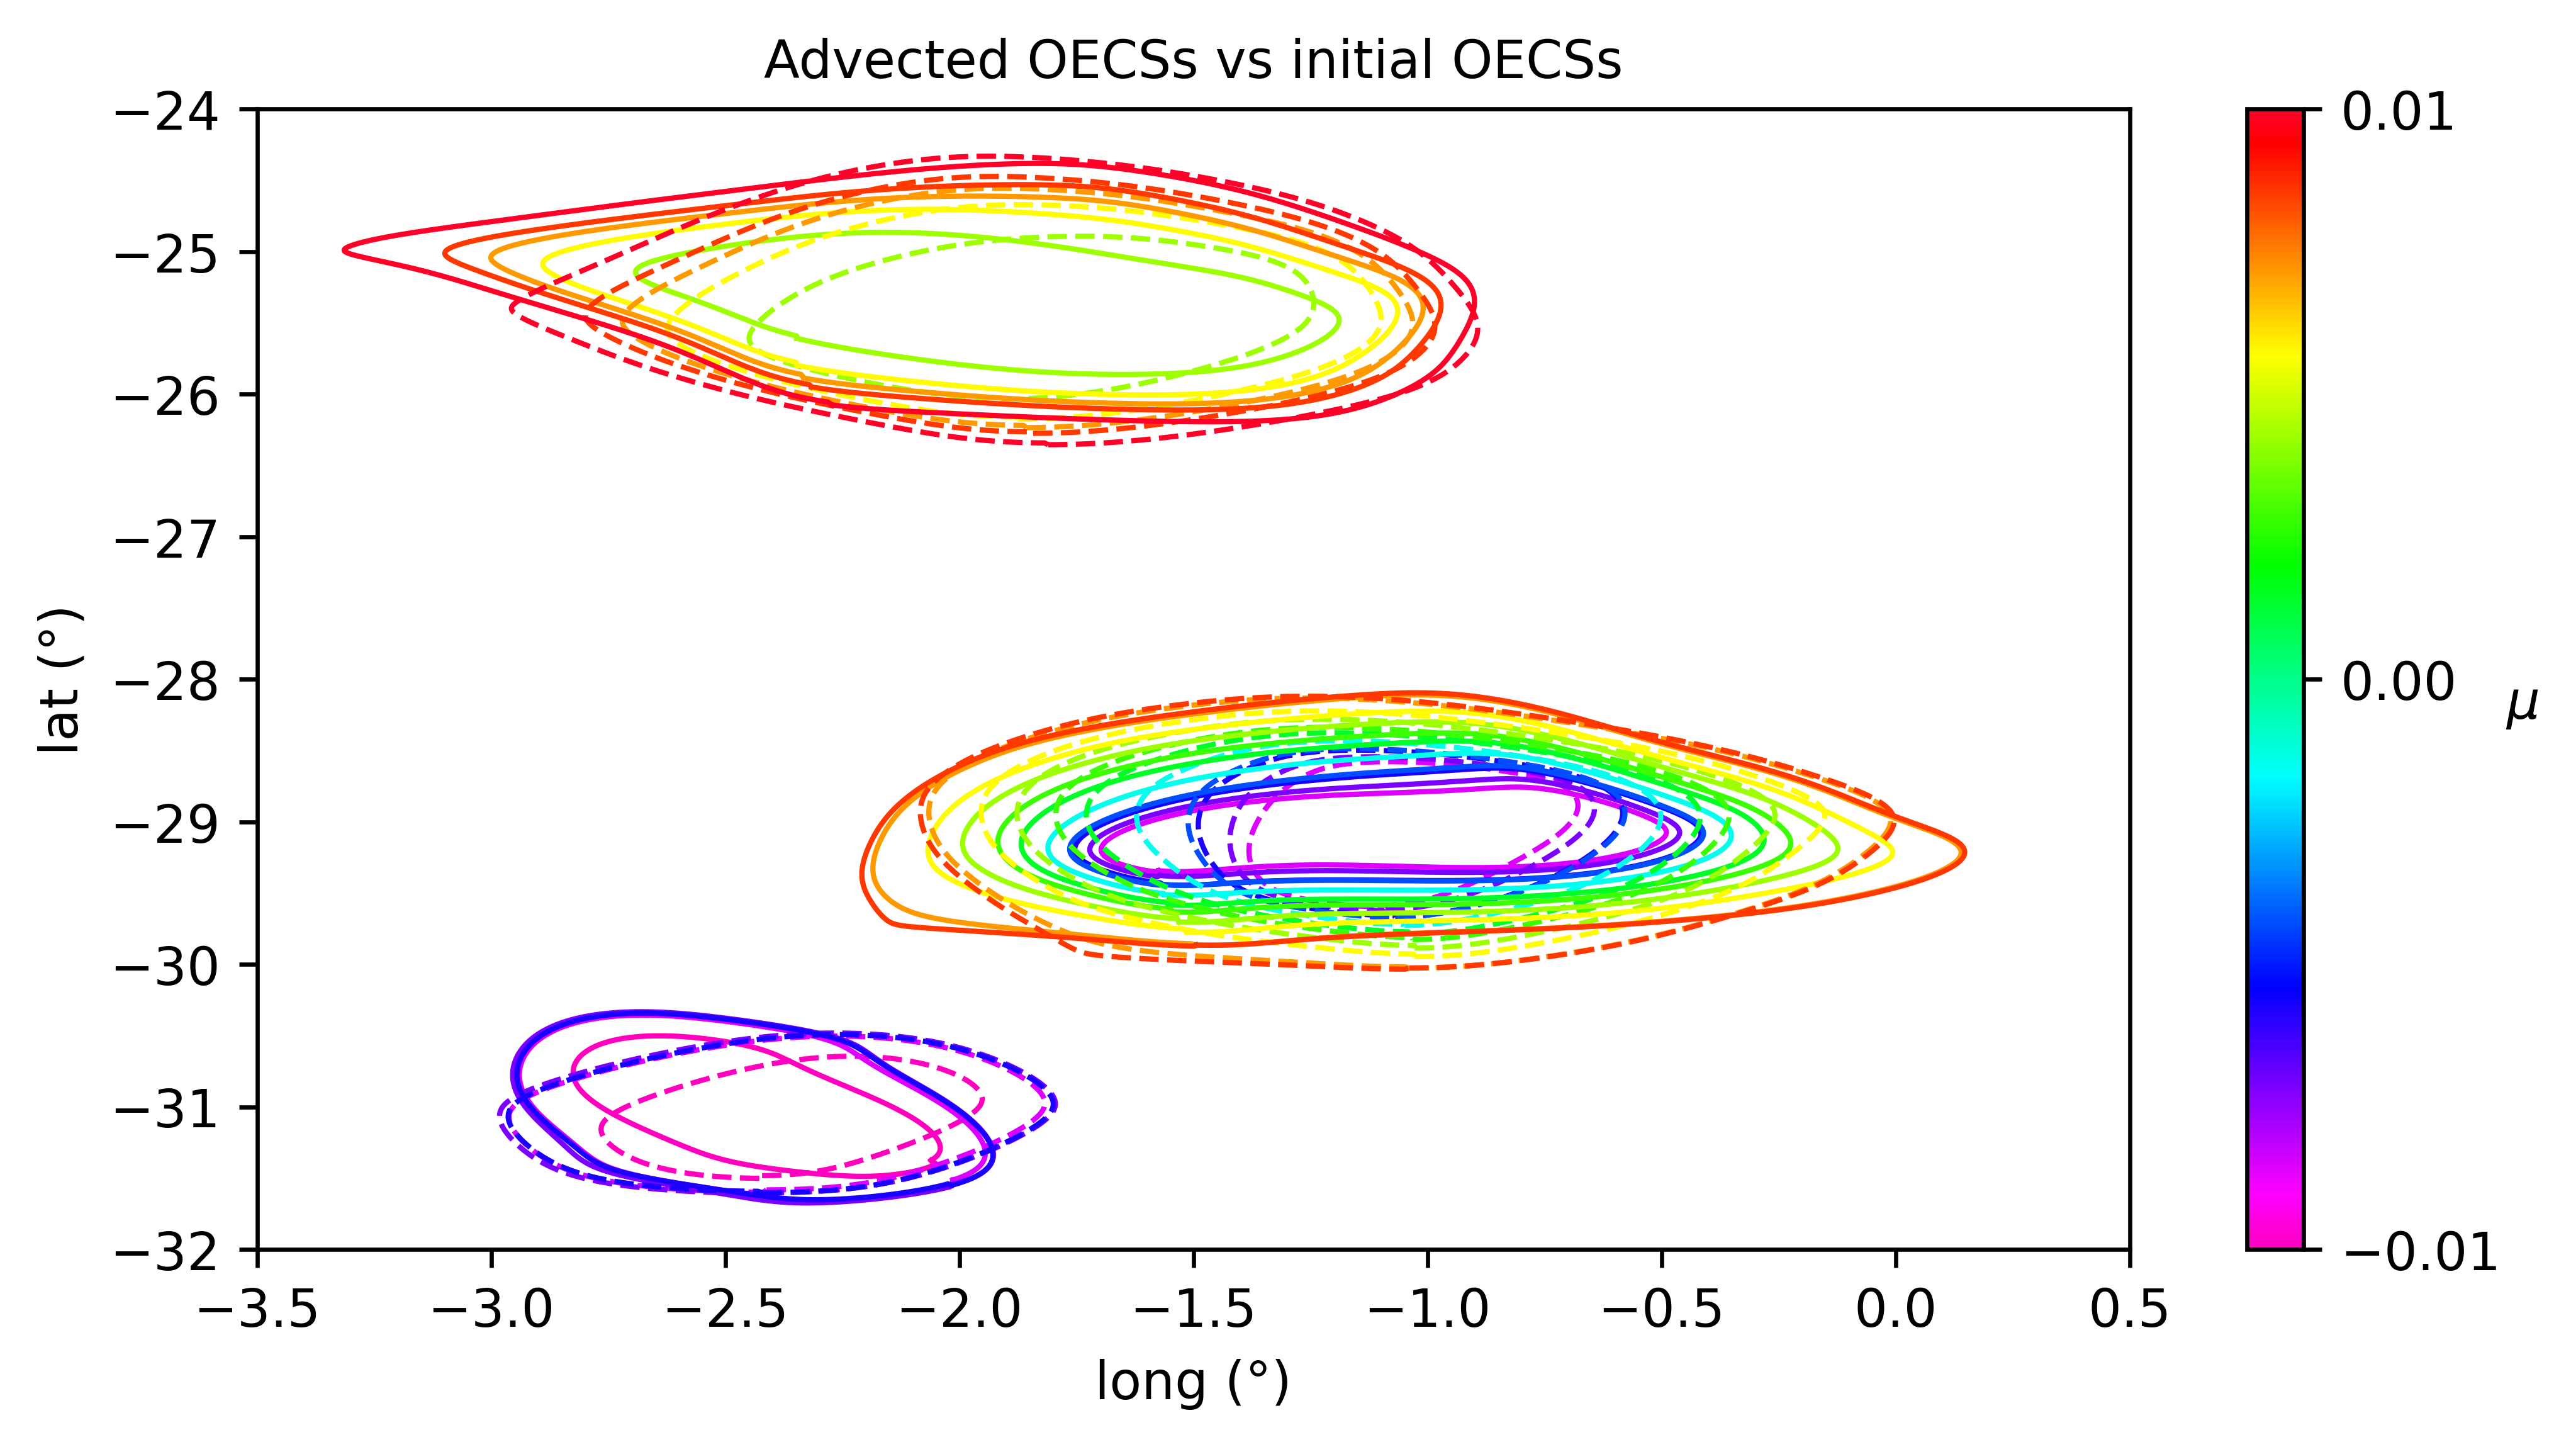

In [11]:
# Import package for computing trajectories
from ipynb.fs.defs.integration_dFdt import integration_dFdt

# efine time-horizon over which to advect
time_advect = np.linspace(t_OECS, t_OECS+3, 100, endpoint = True)

# Define figure/axes
fig = plt.figure(figsize = (8, 4), dpi = 600)
ax = plt.axes()

# Define norm/cmap
norm = mpl.colors.Normalize(vmin=mu_range.min(), vmax=mu_range.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap='gist_rainbow_r')#mpl.cm.jet)

# Iterate over all elliptic OECS and plot
for i in range(len(Elliptic_OECS)):
    # dummy plot
    ax.scatter(np.nan, np.nan, s = 1, color=cmap.to_rgba(mu_range[i]))
    if Elliptic_OECS[i][0] is not None:
        for j in range(len(Elliptic_OECS[i][0])):
            if Elliptic_OECS[i][0][j] is not None:
                ax.plot(Elliptic_OECS[i][0][j], Elliptic_OECS[i][1][j], c=cmap.to_rgba(mu_range[i]), linewidth = 1, linestyle = "dashed")
                x_advected, y_advected = [], []
                
                # advecte Elliptic OECS
                for t in range(len(Elliptic_OECS[i][0][j])):
                    
                    x = np.array([Elliptic_OECS[i][0][j][t], Elliptic_OECS[i][1][j][t]])
                    
                    # Advect OECS over 3 days
                    Fmap = integration_dFdt(time_advect, x, X, Y, Interpolant, periodic, defined_domain, bool_unsteady, dt_data, delta)[0]

                    # extract end-point of advection
                    x_end = Fmap[:,-1]
                    
                    x_advected.append(x_end[0])
                    y_advected.append(x_end[1])
                ax.plot(x_advected, y_advected, c=cmap.to_rgba(mu_range[i]), linewidth = 1)

# Set axis limits
ax.set_xlim([-3.5, 0.5])
ax.set_ylim([-32, -24])
                
# Set axis labels
ax.set_xlabel("long (°)", fontsize = 10)
ax.set_ylabel("lat (°)", fontsize = 10)

# Colorbar
cbar = fig.colorbar(cmap, ticks=[mu_range.min(), 0, mu_range.max()])
cbar.ax.set_ylabel(r'$ \mu $', rotation = 0, fontsize = 10)

# Title
ax.set_title("Advected OECSs vs initial OECSs", fontsize = 10)
plt.show();

# References

[1] Serra, M., & Haller, G. (2017). Efficient computation of null geodesics with applications to coherent vortex detection. Proceedings of the Royal Society A: Mathematical, Physical and Engineering Sciences, 473(2199).